<a href="https://colab.research.google.com/github/MoayadBatwa/NLP-SentimentAnalysis/blob/main/SentimentAnalysis_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step	Description

Step 0: Setup & InstallationInstalled necessary libraries (kagglehub, nltk) and downloaded NLTK resources (wordnet, omw-1.4) for advanced text processing.

Step 1: Data LoadingFetched the "Sentiment Analysis for Mental Health" dataset dynamically using the KaggleHub API and loaded it into a DataFrame.

Step 2: Advanced PreprocessingCleaned text by removing special characters and stopwords.Applied WordNet Lemmatization to reduce words to their base forms (e.g., "running" $\rightarrow$ "run") for better consistency.

Step 3: Feature Extraction (N-Grams)Converted text data into numerical vectors using TF-IDF with Bigrams (1,2 n-grams) to capture context between adjacent words.

Step 4: Data SplittingDivided the dataset into Training (80%) and Testing (20%) sets with a fixed random seed for reproducibility.

Step 5: Model Training (Balanced)Trained a Logistic Regression classifier using class_weight='balanced' to automatically adjust for imbalances in the mental health categories.

Step 6: EvaluationEvaluated model performance using Accuracy Score and a Classification Report to analyze Precision, Recall, and F1-Score for all 7 classes.

Step 7: VisualizationGenerated a Confusion Matrix to visually identify which mental health statuses were most frequently confused by the model.

Step 8: InferenceCreated a custom batch prediction function to classify a list of new, unseen user statements into mental health categories.

## Step 0: Install Libraries

In [80]:
pip install pandas nltk matplotlib seaborn kagglehub

## Step 1: Imports and Setup

In [81]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Step 2: Loading and Inspecting Data

In [82]:
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentiment-analysis-for-mental-health' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-for-mental-health


Sample of the dataset:
    status                                          statement
0  Anxiety                                         oh my gosh
1  Anxiety  trouble sleeping, confused mind, restless hear...
2  Anxiety  All wrong, back off dear, forward doubt. Stay ...
3  Anxiety  I've shifted my focus to something else but I'...
4  Anxiety  I'm restless and restless, it's been a month n...



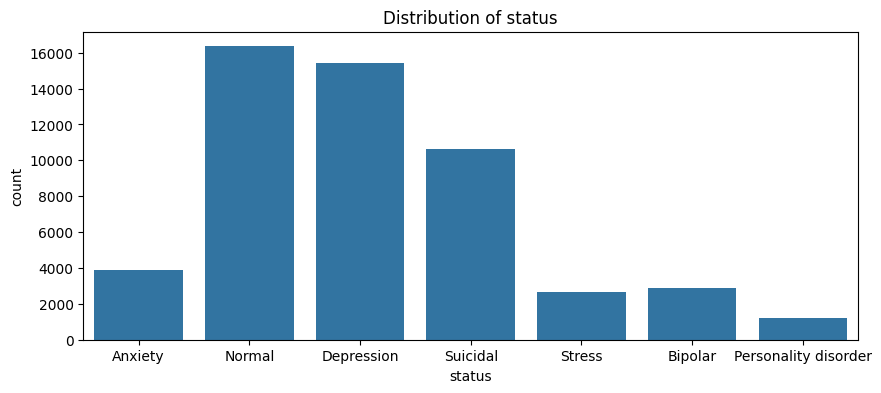

In [83]:
df = pd.read_csv(os.path.join(path, "Combined Data.csv"))

print("Sample of the dataset:")
print(df[['status', 'statement']].head())
print()
plt.figure(figsize=(10,4))
sns.countplot(x='status', data=df)
plt.title('Distribution of status')
plt.show()

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


## Step 3: Data Preprocessing

In [85]:
# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#  Helper function to convert NLTK tags to WordNet tags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # Default to Noun if unsure

#  Cleaning Function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()

    filtered_words = []
    for w in words:
        if w not in stop_words:
            # Get the correct POS tag for this specific word
            pos_tag = get_wordnet_pos(w)
            # Lemmatize with the correct tag
            lemma = lemmatizer.lemmatize(w, pos=pos_tag)
            filtered_words.append(lemma)

    return " ".join(filtered_words)


# Drop rows where 'statement' is missing
df.dropna(subset=['statement'], inplace=True)

# Test it
df['clean_text'] = df['statement'].apply(clean_text)

print("Preprocessing complete with Lemmatization.")
print(df[['statement', 'clean_text']].head())


# Replace empty strings '' or whitespace ' ' with NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Drop rows where any data is missing
df.dropna(inplace=True)

Preprocessing complete with Lemmatization.
                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                          clean_text  
0                                            oh gosh  
1     trouble sleep confuse mind restless heart tune  
2  wrong back dear forward doubt stay restless re...  
3    ive shift focus something else im still worried  
4                im restless restless month boy mean  


## Step 4: Feature Extraction (TF-IDF)

In [86]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['status']

## Step 5: Splitting the Dataset

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

## Step 6: Model Training

In [88]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

## Step 7: Evaluation

In [89]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 75.96%

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.77      0.82      0.79       811
             Bipolar       0.78      0.81      0.80       591
          Depression       0.80      0.62      0.70      3097
              Normal       0.88      0.90      0.89      3134
Personality disorder       0.52      0.83      0.64       239
              Stress       0.53      0.69      0.60       545
            Suicidal       0.65      0.73      0.69      2093

            accuracy                           0.76     10510
           macro avg       0.70      0.77      0.73     10510
        weighted avg       0.77      0.76      0.76     10510



## Step 8: Visualization of Results

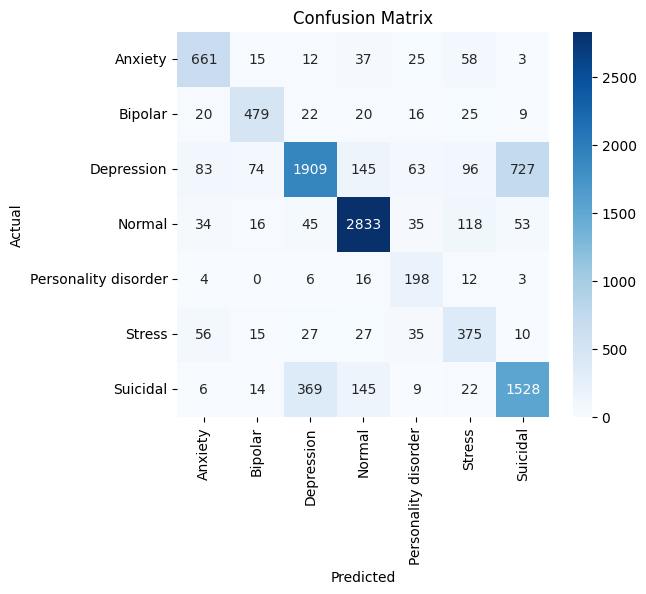

In [90]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

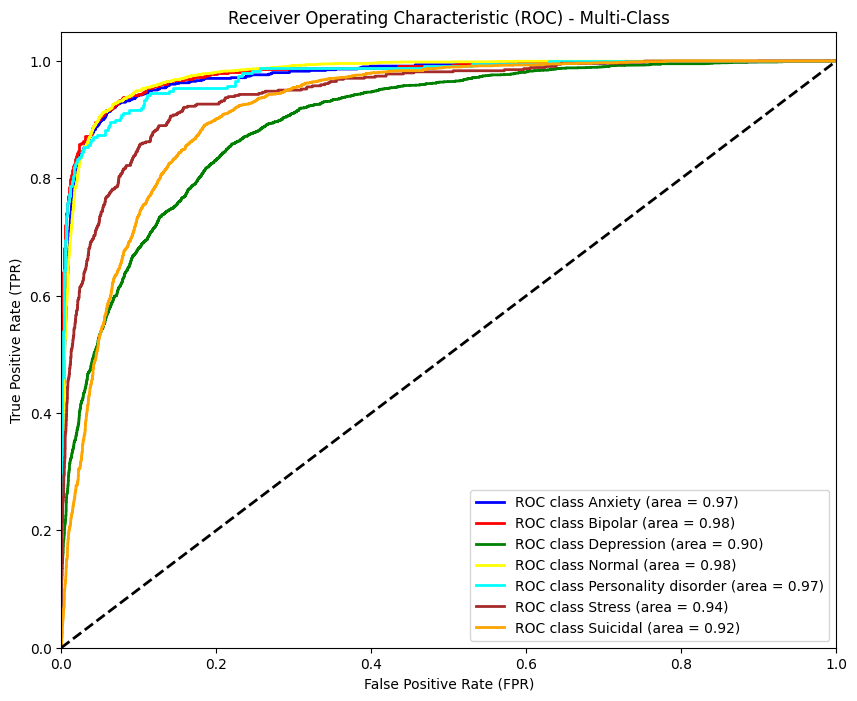

In [91]:
classes = model.classes_
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'cyan', 'brown', 'orange']) # Assign a color to each class

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()

## Step 8: Batch Prediction (List of Inputs)

In [92]:
def predict_batch(input_list):
    print(f"\n--- Processing {len(input_list)} Statements ---\n")

    for text in input_list:
        cleaned = clean_text(text)

        vectorized = tfidf.transform([cleaned]).toarray()

        prediction = model.predict(vectorized)[0]

        print(f"Statement: '{text}'")
        print(f"Prediction: {prediction.upper()}")
        print("-" * 30)

user_inputs = [
    "I don't want to be worried but my heart races for no reason.",
    "I simply cannot get out of bed today, everything feels hopeless.",
    "Today was actually a really nice day, I enjoyed a walk outside.",
    "I've graduated from university and I have massive amounts of stress going on with job hunting. I live with parents who are constantly on my back and getting angry with me for not having a job.",
    "I cannot go out again, nothing left for me in life.",
    "How do you deal with your kids while on a manic? I just need some advice or coping help.",
    "Am I doomed? I recently got diagnosed with AVPD and I feel completely hopeless. This is me, and I will stay like this my whole life. Am I going to get my dream job? Have a fun life? Travel around the world? Apparently not. I'm 22 and I feel like I'm 60"
]

predict_batch(user_inputs)


--- Processing 7 Statements ---

Statement: 'I don't want to be worried but my heart races for no reason.'
Prediction: ANXIETY
------------------------------
Statement: 'I simply cannot get out of bed today, everything feels hopeless.'
Prediction: DEPRESSION
------------------------------
Statement: 'Today was actually a really nice day, I enjoyed a walk outside.'
Prediction: NORMAL
------------------------------
Statement: 'I've graduated from university and I have massive amounts of stress going on with job hunting. I live with parents who are constantly on my back and getting angry with me for not having a job.'
Prediction: STRESS
------------------------------
Statement: 'I cannot go out again, nothing left for me in life.'
Prediction: SUICIDAL
------------------------------
Statement: 'How do you deal with your kids while on a manic? I just need some advice or coping help.'
Prediction: BIPOLAR
------------------------------
Statement: 'Am I doomed? I recently got diagnosed with A